# Final Project Computer Vision
## Truth in Motion: Depth and Flow Enhanced DeepFake Detection

Authors: Aimee Lin, Neli Catar and Gellert Toth

### Imports

In [ ]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [ ]:
!mkdir -p DepthAnythingV2Checkpoints
!curl -L https://huggingface.co/depth-anything/Depth-Anything-V2-Base/resolve/main/depth_anything_v2_vitb.pth?download=true --output DepthAnythingV2Checkpoints/depth_anything_v2_vitb.pth


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1150  100  1150    0     0   2602      0 --:--:-- --:--:-- --:--:--  2601
100  371M  100  371M    0     0   261M      0  0:00:01  0:00:01 --:--:--  453M


In [ ]:
!git clone https://github.com/sniklaus/pytorch-pwc.git
!mv pytorch-pwc pytorch_pwc

Cloning into 'pytorch-pwc'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 251 (delta 40), reused 62 (delta 24), pack-reused 169 (from 1)
Receiving objects: 100% (251/251), 66.96 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [ ]:
!pip install -r requirements.txt --extra-index-url https://download.pytorch.org/whl/cu121

In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import re
import sys
import torch
import json
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.transforms as T
import seaborn as sns

from facenet_pytorch import MTCNN
from IPython.display import display
from matplotlib import colors
from PIL import Image, ImageShow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoModel, AutoImageProcessor
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time
from torch.cuda.amp import GradScaler, autocast


depth_anything_path = os.path.abspath("Depth-Anything-V2")

if depth_anything_path not in sys.path:
    sys.path.append(depth_anything_path)
from depth_anything_v2.dpt import DepthAnythingV2

argv_backup = sys.argv
sys.argv = [sys.argv[0]]
from pytorch_pwc.run import estimate
sys.argv = argv_backup

Download data if running in colab

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Colab Data/'
extract_path = '/content/.'

# Create the destination folder
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(os.path.join(zip_path, "flow_data.zip"), 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(os.path.join(zip_path, "depth_data.zip"), 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Globals

In [ ]:
# data folders
video_root = './data' # where the data is stored
data_root = './preprocessed_data' # where the pre processed data gets stored
data_flow = "./flow_data" # where flow data gets saved
data_depth = "./depth_data"
training_progress_path = "./training_progress"

os.makedirs(training_progress_path, exist_ok=True)

# data loading
BATCH_SIZE = 256 # batch size of the preprocessed data

# device
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(DEVICE)
# training
NUM_EPOCHS = 15 # epochs when training
SKIP_FRAMES = 3 # When processing the video jump some frames to reduce data size


cuda


### Utils

In [ ]:
def split_video_into_frames(path, save_path):
    """
      Split the video into frames and save all pictures on disk
    """
    cap = cv2.VideoCapture(path)

    frames = []
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        frames.append(frame)

    cap.release()

    faces = [frame_faces for i in range(0, len(frames), BATCH_SIZE) for frame_faces in mtcnn(frames[i:min(len(frames),i+BATCH_SIZE)])]

    os.makedirs(save_path, exist_ok=True)
    for i, frame_faces in enumerate(faces):
        if frame_faces is None:
            continue
        face = frame_faces[0]
        img_pil = Image.fromarray(face.permute(1, 2, 0).numpy().astype(np.uint8))
        img_pil.save(os.path.join(save_path, f"frame_{i}.png"))

def list_leaf_folders(root_dir):
    """
      Find all folders that do not contain any subfolders.
      These folders instead will contain pictures of the frames of the video.
    """
    leaf_folders = []
    for dirpath, dirnames, _ in os.walk(root_dir):
        if not dirnames:
            leaf_folders.append(dirpath)
    return leaf_folders

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def list_sorted_images(folder, extensions={'.png', '.jpg', '.jpeg', '.bmp'}):
    """
      Sort images in order of frames
    """
    files = [f for f in os.listdir(folder)
             if os.path.isfile(os.path.join(folder, f)) and os.path.splitext(f)[1].lower() in extensions]
    files.sort(key=natural_sort_key)
    return [os.path.join(folder, f) for f in files]

def flow_to_rgb(flow):
    """
      Convert flow data to RGB image by considering flow vectors as HSV color
      coding.
    """
    u = flow[..., 0]
    v = flow[..., 1]

    magnitude = np.sqrt(u**2 + v**2)
    direction = np.arctan2(v, u)
    mag_max = np.max(magnitude)
    magnitude = magnitude / mag_max if mag_max != 0 else magnitude

    direction = (direction + np.pi) / (2 * np.pi)
    saturation = magnitude
    value = np.ones_like(magnitude)
    hsv_image = np.stack((direction, saturation, value), axis=-1)
    rgb_image = colors.hsv_to_rgb(hsv_image.astype(np.float32))
    return rgb_image

def calculate_flow_picture(img1, img2):
    """
      Pass the images to PWCnet to calculate the flow.
    """
    res = estimate(img1, img2)
    res = np.array(res.numpy(force=True).transpose(1, 2, 0), np.float32)
    res = flow_to_rgb(res)
    return res

def calculate_depth_picture(model, img):
    """
      Pass the image to Depth Anything V2 to calculate depth
    """
    res = model.infer_image(img)
    depth_min = np.min(res)
    depth_max = np.max(res)
    if depth_max - depth_min < 1e-6:
        normalised = np.zeros_like(res, dtype=np.uint8)
    else:
        normalised = 255 * (res - depth_min) / (depth_max - depth_min)
        normalised = normalised.astype(np.uint8)
    return normalised

def collect_video_folders(base_dir):
    """
      Find all folders that contain videos
    """
    folders = []
    for root, dirs, _ in os.walk(base_dir):
        for d in dirs:
            folder_path = os.path.join(root, d)
            # check if it contains frames
            if any(fname.lower().endswith(('.jpg', '.png')) for fname in os.listdir(folder_path)):
                folders.append(folder_path)
    return sorted(folders)

def extract_frame_paths_and_labels(base_dirs, label, split_ratio = [0.7, 0.2, 0.1]):
    """
      Prepare training, validation and test data and obtain fake and real labels
    """
    train_paths = []
    val_paths = []
    test_paths = []

    for base_dir in base_dirs:
        video_folders = collect_video_folders(base_dir)
        total_videos = len(video_folders)

        train_cutoff = int(total_videos * split_ratio[0])
        val_cutoff = int(total_videos * (split_ratio[0] + split_ratio[1]))

        for i, video_folder in enumerate(video_folders):
            frame_paths = glob.glob(os.path.join(video_folder, '*'))
            frame_paths = [f for f in frame_paths if f.lower().endswith(('.jpg', '.png'))]

            labeled = [(fp, label) for fp in frame_paths]

            if i < train_cutoff:
                train_paths.extend(labeled)
            elif i < val_cutoff:
                val_paths.extend(labeled)
            else:
                test_paths.extend(labeled)

    return train_paths, val_paths, test_paths

class FrameDataset(Dataset):
    """
      Class for representing the dataset as a PyTorch Dataset
    """
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label

def repeat_channels(x):
    """
      Repeat the channel to achieve the expected 3 channel input if the image
      is greyscale
    """
    if isinstance(x, torch.Tensor) and x.dim() == 3 and x.shape[0] == 1:
        return x.repeat(3, 1, 1)
    elif isinstance(x, torch.Tensor) and x.dim() == 2:
        # Add channel dimension if missing
        return x.unsqueeze(0).repeat(3, 1, 1)
    else:
        raise ValueError(f"Unexpected input shape for repeat_channels: {x.shape}")

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


def train(model, dataloader, criterion, optimizer, device, scale=True):
    """
      Train one epoch. Calculate loss and accuracy
      @param scale: Wether to use quantization in the form of autocast to fp16
    """
    model.train()
    if scale:
        scaler = GradScaler()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_probs = []
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            if scale:
                with autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()



        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = probs > 0.5
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).detach().numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

def evaluate(model, dataloader, criterion, device, scale=True):
    """
      Eval one epoch. Calculate loss and accuracy
      @param scale: Wether to use quantization in the form of autocast to fp16
    """
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            if scale:
                with autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

def plot_training_progress(train_accuracies, val_accuracies, train_aurocs, val_aurocs, save_path=None):
    """
    Create plots of training/validation accuracy and AUROC over epochs.
    """
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, marker='o', linewidth=2, label='Train Accuracy', color='#1f77b4')
    plt.plot(epochs, val_accuracies, marker='s', linewidth=2, label='Validation Accuracy', color='#ff7f0e')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.ylim(0.2, 1.0)
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # AUROC Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_aurocs, marker='o', linewidth=2, label='Train AUROC', color='#2ca02c')
    plt.plot(epochs, val_aurocs, marker='s', linewidth=2, label='Validation AUROC', color='#d62728')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.title('Training vs Validation AUROC')
    plt.ylim(0.2, 1.0)
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_auc_curve(y_true, y_scores, title="ROC Curve", save_path=None):
    """
    Plot ROC Curve with AUC score.
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#1f77b4', lw=3, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def train_fp16_distilattion(model_learner, model_teacher, dataloader, criterion, optimizer, device):
    """
      Train one distilattion epoch. Calculate loss and accuracy
    """
    scaler = GradScaler()
    model_learner.train()
    model_teacher.train()
    all_labels = []
    all_probs = []
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad()
        with torch.no_grad():
            with autocast(dtype=torch.float16):
                cls_token_teacher = model_teacher(images)
                cls_token_teacher = cls_token_teacher.detach()
        with torch.set_grad_enabled(True):
            with autocast(dtype=torch.float16):
                cls_token_teacher_projected = model_learner.cls_projector(cls_token_teacher)
                cls_token, outputs  = model_learner(images)

                loss = criterion(outputs, labels, cls_token, cls_token_teacher_projected)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = probs > 0.5
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

def evaluate_fp16_distilattion(model_learner, model_teacher, dataloader, criterion, device):
    """
      Eval one distillation epoch. Calculate loss and accuracy
    """
    model_teacher.eval()
    model_learner.eval()
    all_labels, all_probs = [], []
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(1)

            with autocast(dtype=torch.float16):
                cls_token_teacher = model_teacher(images)
                cls_token_teacher = cls_token_teacher.detach()
                cls_token_teacher_projected = model_learner.cls_projector(cls_token_teacher)
                cls_token, outputs = model_learner(images)

                loss = criterion(outputs, labels, cls_token, cls_token_teacher_projected)

            running_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

class DistillationLoss(nn.Module):
    """
      Loss for distillation training. Combines KL divergence and BCE loss
    """
    def __init__(self, alpha=0.9, temperature=1.0):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.bce = nn.BCEWithLogitsLoss()
        self.distill_loss = self._kl_loss

    def forward(self, student_output, labels, student_cls, teacher_cls):
        cls_loss = self.bce(student_output, labels)
        distill = self.distill_loss(student_cls, teacher_cls)
        total_loss = self.alpha * cls_loss + (1 - self.alpha) * distill
        return total_loss

    def _kl_loss(self, student_cls, teacher_cls):
        T = self.temperature
        student_log_probs = F.log_softmax(student_cls / T, dim=-1)
        teacher_probs = F.softmax(teacher_cls / T, dim=-1)
        return F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

def prepare_data_loaders(original_sources, manipulated_sources):
    """
      Prepare training, validaiton and test dataloaders
    """
    # Collect data
    train_real, val_real, test_real = extract_frame_paths_and_labels(original_sources, label=0)
    train_fake, val_fake, test_fake = extract_frame_paths_and_labels(manipulated_sources, label=1)

    # Combine
    train_data = train_real + train_fake
    val_data = val_real + val_fake
    test_data = test_real + test_fake

    # Sample output
    print(f"Training samples: {len(train_data)}")
    print(f"Testing samples: {len(test_data)}")
    print(f"Sample training item: {train_data[0]}")

    train_dataset = FrameDataset(train_data, transform=image_transform)
    val_dataset = FrameDataset(val_data, transform=image_transform)
    test_dataset = FrameDataset(test_data, transform=image_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader, test_loader

def train_full_model(model, original_sources, manipulated_sources, model_name, scale=True):
    """
      Train full model from scratch
      @param scale: Wether to use quantization in the form of autocast to fp16
    """
    train_loader, val_loader, test_loader = prepare_data_loaders(original_sources, manipulated_sources)

    train_accuracies, val_accuracies = [], []
    train_aurocs, val_aurocs = [], []
    epoch_times = []

    start_epoch = 1

    criterion = torch.nn.BCEWithLogitsLoss()
    backbone_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            if "backbone" in name:
                backbone_params.append(param)
            else:
                classifier_params.append(param)
    print(len(backbone_params), len(classifier_params))
    optimizer = torch.optim.Adam([
        {"params": backbone_params, "lr": 1e-5},
        {"params": classifier_params, "lr": 1e-4},
    ])
    best_epoch, best_val = -1, 1e9
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        save_path = os.path.join("checkpoints", f"{model_name}_epoch_{epoch}.pth")
        epoch_start = time.time()

        train_loss, train_acc, train_labels, train_probs = train(model, train_loader, criterion, optimizer, DEVICE, scale)
        val_loss, val_acc, val_labels, val_probs = evaluate(model, val_loader, criterion, DEVICE, scale)

        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
        # AUROC
        train_auroc = roc_auc_score(train_labels, train_probs)
        val_auroc = roc_auc_score(val_labels, val_probs)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_aurocs.append(train_auroc)
        val_aurocs.append(val_auroc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUROC: {train_auroc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUROC: {val_auroc:.4f}")
        print(f"Epoch time: {epoch_time:.2f} seconds")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, save_path)

    model_data = torch.load( os.path.join("checkpoints", f"{model_name}_epoch_{best_epoch}.pth"))
    model.load_state_dict(model_data["model_state_dict"])
    torch.save({
        "model_state_dict": model.state_dict()
    }, os.path.join("checkpoints", f"{model_name}_final.pth"))
    with open(os.path.join(training_progress_path, model_name), "w") as f:
      json.dump({
          "train_accuracies": train_accuracies,
          "val_accuracies": val_accuracies,
          "train_aurocs": train_aurocs,
          "val_aurocs": val_aurocs,
          "epoch_times": epoch_times
      }, f)



def train_full_model_distillation(model, teacher_model, original_sources, manipulated_sources, model_name):
    """
      Train full model from scratch while distilling teacher model
    """
    train_loader, val_loader, test_loader = prepare_data_loaders(original_sources, manipulated_sources)

    train_accuracies, val_accuracies = [], []
    train_aurocs, val_aurocs = [], []
    epoch_times = []

    start_epoch = 1

    criterion = DistillationLoss()
    backbone_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            if "backbone" in name:
                backbone_params.append(param)
            else:
                classifier_params.append(param)
    print(len(backbone_params), len(classifier_params))
    optimizer = torch.optim.Adam([
        {"params": backbone_params, "lr": 5e-5},
        {"params": classifier_params, "lr": 1e-4},
    ])
    best_epoch, best_val = -1, 1e9
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        save_path = os.path.join("checkpoints", f"{model_name}_epoch_{epoch}.pth")
        epoch_start = time.time()

        train_loss, train_acc, train_labels, train_probs = train_fp16_distilattion(model, teacher_model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc, val_labels, val_probs = evaluate_fp16_distilattion(model, teacher_model, val_loader, criterion, DEVICE)

        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
        # AUROC
        train_auroc = roc_auc_score(train_labels, train_probs)
        val_auroc = roc_auc_score(val_labels, val_probs)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_aurocs.append(train_auroc)
        val_aurocs.append(val_auroc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUROC: {train_auroc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUROC: {val_auroc:.4f}")
        print(f"Epoch time: {epoch_time:.2f} seconds")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, save_path)

    model_data = torch.load( os.path.join("checkpoints", f"{model_name}_epoch_{best_epoch}.pth"))
    model.load_state_dict(model_data["model_state_dict"])
    torch.save({
        "model_state_dict": model.state_dict()
    }, os.path.join("checkpoints", f"{model_name}_final.pth"))
    with open(os.path.join(training_progress_path, model_name), "w") as f:
      json.dump({
          "train_accuracies": train_accuracies,
          "val_accuracies": val_accuracies,
          "train_aurocs": train_aurocs,
          "val_aurocs": val_aurocs,
          "epoch_times": epoch_times
      }, f)

def evaluate_trained_model(model, model_name, original_sources, manipulated_sources, scale=True):
  with open(os.path.join(training_progress_path, model_name)) as f:
      train_progress_data = json.load(f)
  plot_training_progress(train_progress_data["train_accuracies"],
                         train_progress_data["val_accuracies"],
                         train_progress_data["train_aurocs"],
                         train_progress_data["val_aurocs"],
                         save_path=os.path.join(training_progress_path, f"{model_name}_progress_plot"))
  _, _, test_loader = prepare_data_loaders(original_sources, manipulated_sources)
  start = time.time()
  test_loss, test_acc, test_labels, test_probs = evaluate(model, test_loader, torch.nn.BCEWithLogitsLoss(), DEVICE, scale)
  runtime = time.time() - start
  plot_auc_curve(test_labels, test_probs, title=f"AUC Curve, eval done in {runtime:.4f} seconds, accuracy: {test_acc:.4f}", save_path=os.path.join(training_progress_path, f"{model_name}_auc_plot"))

def prepare_backbone(model_name):
  processor = AutoImageProcessor.from_pretrained(model_name)
  backbone = AutoModel.from_pretrained(model_name)
  for param in backbone.parameters():
    param.requires_grad = False

  for name, param in backbone.named_parameters():
      if "encoder.layer.11" in name:
          param.requires_grad = True

  return backbone

### Data

Code for downloading the data is based on FaceForensics++ dataset and is available on https://github.com/ondyari/FaceForensics

#### Feature extraction generation

In the sections below we tested the feature extraction generation techniques

1. Splitting the videos into frames

In [ ]:
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device=DEVICE)

for dirpath, _, filenames in os.walk(video_root):
    if len(filenames) == 0:
        continue
    print(f"Processing videos in {dirpath}")
    for file in tqdm(filenames):
        if file.endswith('.mp4'):
            video_path = os.path.join(dirpath, file)
            relative_path = os.path.relpath(video_path, video_root)
            output_folder = os.path.join(data_root, os.path.splitext(relative_path)[0])
            split_video_into_frames(video_path, output_folder)



2. Calculating Optical Flow

In [ ]:
leaf_folders = list_leaf_folders(data_root)
print(leaf_folders)
for folder in tqdm(leaf_folders):
    relative_path = os.path.relpath(folder, data_root)
    images = list_sorted_images(folder)
    images = [torch.FloatTensor(np.ascontiguousarray(np.array(Image.open(image))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0))) for image in images]
    for i in range(0, len(images)-1, SKIP_FRAMES):
        img1, img2 = images[i], images[i+1]
        res = calculate_flow_picture(img1, img2)
        save_path = os.path.join(data_flow, relative_path)
        os.makedirs(save_path, exist_ok=True)
        rgb_flow_uint8 = (res * 255).astype(np.uint8)
        pil_img = Image.fromarray(rgb_flow_uint8, mode='RGB')
        pil_img.save(os.path.join(save_path, f"flow_image_{i}.png"))

3. Depth Estimation

In [ ]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

model = DepthAnythingV2(**model_configs['vitb'])
model.load_state_dict(torch.load(f'DepthAnythingV2Checkpoints/depth_anything_v2_vitb.pth', map_location='cpu'))
model = model.to(DEVICE).eval()


leaf_folders = list_leaf_folders(data_root)
for folder in tqdm(leaf_folders):
    relative_path = os.path.relpath(folder, data_root)
    images = list_sorted_images(folder)
    for i in range(0, len(images), SKIP_FRAMES):
        img_path = images[i]
        img = np.array(Image.open(img_path))
        res = calculate_depth_picture(model, img)
        save_path = os.path.join(data_depth, relative_path)
        os.makedirs(save_path, exist_ok=True)
        pil_img = Image.fromarray(res, mode='L')
        pil_img.save(os.path.join(save_path, f"depth_image_{i}.png"))

100%|██████████| 400/400 [2:57:51<00:00, 26.68s/it]  


### Network

In [ ]:
class DinoBinaryClassifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1, bias=True)  # binary output
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, nonlinearity='relu')
                init.zeros_(layer.bias)
    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0]
        return self.classifier(cls_token)

class DinoBinaryClassifierForDistilattion(DinoBinaryClassifier):
    def __init__(self, backbone):
        super().__init__(backbone)
        self.inference = False
        self.cls_projector = nn.Linear(768, 384)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0]
        if(self.inference):
          return self.classifier(cls_token)
        return cls_token, self.classifier(cls_token)


class DinoBinaryClassifierForDistilattionTeacher(DinoBinaryClassifier):
    def __init__(self, backbone):
        super().__init__(backbone)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0]
        return cls_token

## Train

#### Flow based network

In [ ]:
# Define your paths
original_sources_flow = [
    'flow_data/original_sequences/actors/c23/videos',
    'flow_data/original_sequences/youtube/c23/videos'
]

manipulated_sources_flow = [
    'flow_data/manipulated_sequences/DeepFakeDetection/c23/videos',
    'flow_data/manipulated_sequences/Deepfakes/c23/videos',
    # 'flow_data/manipulated_sequences/Face2Face/c23/videos',
    # 'flow_data/manipulated_sequences/FaceShifter/c23/videos',
    # 'flow_data/manipulated_sequences/FaceSwap/c23/videos',
    # 'flow_data/manipulated_sequences/NeuralTextures/c23/videos'
]

In [ ]:
backbone = prepare_backbone("facebook/dinov2-base")
model = DinoBinaryClassifier(backbone)
model.to(DEVICE);

In [ ]:
train_full_model(model, original_sources_flow, manipulated_sources_flow, "flow_dinov2_base_fp16")

Training samples: 60365
Testing samples: 10762
Sample training item: ('flow_data/original_sequences/actors/c23/videos/01__hugging_happy/flow_image_147.png', 0)
18 4


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 1/15
Train Loss: 0.7323 | Train Acc: 0.5252 | Train AUROC: 0.5259
Val Loss: 0.6931 | Val Acc: 0.5317 | Val AUROC: 0.5283
Epoch time: 200.60 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 2/15
Train Loss: 0.6870 | Train Acc: 0.5422 | Train AUROC: 0.5517
Val Loss: 0.6930 | Val Acc: 0.5343 | Val AUROC: 0.5349
Epoch time: 200.43 seconds


100%|██████████| 65/65 [00:38<00:00,  1.68it/s]


Epoch 3/15
Train Loss: 0.6840 | Train Acc: 0.5502 | Train AUROC: 0.5653
Val Loss: 0.6899 | Val Acc: 0.5378 | Val AUROC: 0.5536
Epoch time: 200.29 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 4/15
Train Loss: 0.6812 | Train Acc: 0.5590 | Train AUROC: 0.5763
Val Loss: 0.7039 | Val Acc: 0.5314 | Val AUROC: 0.5384
Epoch time: 200.45 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 5/15
Train Loss: 0.6793 | Train Acc: 0.5631 | Train AUROC: 0.5837
Val Loss: 0.6891 | Val Acc: 0.5522 | Val AUROC: 0.5602
Epoch time: 200.76 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 6/15
Train Loss: 0.6761 | Train Acc: 0.5710 | Train AUROC: 0.5948
Val Loss: 0.6889 | Val Acc: 0.5574 | Val AUROC: 0.5689
Epoch time: 200.56 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 7/15
Train Loss: 0.6726 | Train Acc: 0.5759 | Train AUROC: 0.6034
Val Loss: 0.6886 | Val Acc: 0.5520 | Val AUROC: 0.5662
Epoch time: 200.69 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 8/15
Train Loss: 0.6689 | Train Acc: 0.5838 | Train AUROC: 0.6141
Val Loss: 0.6972 | Val Acc: 0.5520 | Val AUROC: 0.5589
Epoch time: 200.62 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 9/15
Train Loss: 0.6643 | Train Acc: 0.5888 | Train AUROC: 0.6236
Val Loss: 0.6924 | Val Acc: 0.5565 | Val AUROC: 0.5700
Epoch time: 200.84 seconds


100%|██████████| 65/65 [00:39<00:00,  1.67it/s]


Epoch 10/15
Train Loss: 0.6594 | Train Acc: 0.5988 | Train AUROC: 0.6362
Val Loss: 0.6953 | Val Acc: 0.5497 | Val AUROC: 0.5613
Epoch time: 200.60 seconds


100%|██████████| 65/65 [00:39<00:00,  1.67it/s]


Epoch 11/15
Train Loss: 0.6544 | Train Acc: 0.6046 | Train AUROC: 0.6461
Val Loss: 0.7015 | Val Acc: 0.5567 | Val AUROC: 0.5710
Epoch time: 200.56 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 12/15
Train Loss: 0.6486 | Train Acc: 0.6133 | Train AUROC: 0.6574
Val Loss: 0.6962 | Val Acc: 0.5671 | Val AUROC: 0.5813
Epoch time: 200.42 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 13/15
Train Loss: 0.6413 | Train Acc: 0.6199 | Train AUROC: 0.6697
Val Loss: 0.6968 | Val Acc: 0.5658 | Val AUROC: 0.5867
Epoch time: 200.74 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 14/15
Train Loss: 0.6308 | Train Acc: 0.6313 | Train AUROC: 0.6856
Val Loss: 0.7019 | Val Acc: 0.5670 | Val AUROC: 0.5816
Epoch time: 200.75 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 15/15
Train Loss: 0.6203 | Train Acc: 0.6424 | Train AUROC: 0.7026
Val Loss: 0.7104 | Val Acc: 0.5697 | Val AUROC: 0.5849
Epoch time: 200.67 seconds


#### Depth Based network

In [ ]:
# Define your paths
original_sources_depth = [
    'depth_data/original_sequences/actors/c23/videos',
    'depth_data/original_sequences/youtube/c23/videos'
]

manipulated_sources_depth = [
    'depth_data/manipulated_sequences/DeepFakeDetection/c23/videos',
    'depth_data/manipulated_sequences/Deepfakes/c23/videos',
    # 'depth_data/manipulated_sequences/Face2Face/c23/videos',
    # 'depth_data/manipulated_sequences/FaceShifter/c23/videos',
    # 'depth_data/manipulated_sequences/FaceSwap/c23/videos',
    # 'depth_data/manipulated_sequences/NeuralTextures/c23/videos'
]

In [ ]:
backbone = prepare_backbone("facebook/dinov2-base")
model = DinoBinaryClassifier(backbone)
model.to(DEVICE);

In [ ]:
train_full_model(model, original_sources_depth, manipulated_sources_depth, "depth_dinov2_base_fp16")

Training samples: 60447
Testing samples: 10777
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_354.png', 0)
18 4


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 1/15
Train Loss: 0.5196 | Train Acc: 0.7341 | Train AUROC: 0.8157
Val Loss: 0.7171 | Val Acc: 0.6880 | Val AUROC: 0.7699
Epoch time: 200.57 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 2/15
Train Loss: 0.2672 | Train Acc: 0.8848 | Train AUROC: 0.9568
Val Loss: 0.7585 | Val Acc: 0.7080 | Val AUROC: 0.7837
Epoch time: 200.67 seconds


100%|██████████| 65/65 [00:39<00:00,  1.67it/s]


Epoch 3/15
Train Loss: 0.1738 | Train Acc: 0.9293 | Train AUROC: 0.9819
Val Loss: 0.9342 | Val Acc: 0.7046 | Val AUROC: 0.7802
Epoch time: 200.70 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 4/15
Train Loss: 0.1232 | Train Acc: 0.9518 | Train AUROC: 0.9909
Val Loss: 1.0673 | Val Acc: 0.6997 | Val AUROC: 0.7719
Epoch time: 200.72 seconds


100%|██████████| 65/65 [00:39<00:00,  1.67it/s]


Epoch 5/15
Train Loss: 0.0952 | Train Acc: 0.9624 | Train AUROC: 0.9945
Val Loss: 1.1632 | Val Acc: 0.6844 | Val AUROC: 0.7563
Epoch time: 200.63 seconds


100%|██████████| 65/65 [00:39<00:00,  1.67it/s]


Epoch 6/15
Train Loss: 0.0741 | Train Acc: 0.9716 | Train AUROC: 0.9967
Val Loss: 1.1843 | Val Acc: 0.6799 | Val AUROC: 0.7597
Epoch time: 200.68 seconds


100%|██████████| 65/65 [00:39<00:00,  1.66it/s]


Epoch 7/15
Train Loss: 0.0599 | Train Acc: 0.9756 | Train AUROC: 0.9979
Val Loss: 1.3637 | Val Acc: 0.6896 | Val AUROC: 0.7896
Epoch time: 200.85 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 8/15
Train Loss: 0.0485 | Train Acc: 0.9805 | Train AUROC: 0.9986
Val Loss: 1.2804 | Val Acc: 0.6936 | Val AUROC: 0.7679
Epoch time: 200.64 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 9/15
Train Loss: 0.0372 | Train Acc: 0.9850 | Train AUROC: 0.9992
Val Loss: 1.4755 | Val Acc: 0.6706 | Val AUROC: 0.7550
Epoch time: 200.64 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 10/15
Train Loss: 0.0331 | Train Acc: 0.9870 | Train AUROC: 0.9994
Val Loss: 1.3210 | Val Acc: 0.6965 | Val AUROC: 0.7747
Epoch time: 200.53 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 11/15
Train Loss: 0.0277 | Train Acc: 0.9889 | Train AUROC: 0.9996
Val Loss: 1.5742 | Val Acc: 0.6849 | Val AUROC: 0.7697
Epoch time: 200.57 seconds


100%|██████████| 65/65 [00:38<00:00,  1.68it/s]


Epoch 12/15
Train Loss: 0.0234 | Train Acc: 0.9903 | Train AUROC: 0.9997
Val Loss: 1.5702 | Val Acc: 0.6823 | Val AUROC: 0.7542
Epoch time: 200.44 seconds


100%|██████████| 65/65 [00:39<00:00,  1.67it/s]


Epoch 13/15
Train Loss: 0.0205 | Train Acc: 0.9916 | Train AUROC: 0.9998
Val Loss: 1.4732 | Val Acc: 0.7062 | Val AUROC: 0.7793
Epoch time: 200.59 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 14/15
Train Loss: 0.0193 | Train Acc: 0.9921 | Train AUROC: 0.9998
Val Loss: 1.8119 | Val Acc: 0.6737 | Val AUROC: 0.7653
Epoch time: 200.60 seconds


100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


Epoch 15/15
Train Loss: 0.0162 | Train Acc: 0.9929 | Train AUROC: 0.9999
Val Loss: 1.8044 | Val Acc: 0.6904 | Val AUROC: 0.7645
Epoch time: 200.61 seconds


### Compression methods

1. Quantization

The models above were trained using fp16 instead of fp32 using autocast. This automatically uses fp16 when it is safe and uses fp32 when it is required. This promises almost no loss in performance while making the model more efficient. To test this we can train a model while turning this feature off.

In [ ]:
backbone = prepare_backbone("facebook/dinov2-base")
model = DinoBinaryClassifier(backbone)
model.to(DEVICE);

In [ ]:
train_full_model(model, original_sources_depth, manipulated_sources_depth, "depth_dinov2_base_fp32", scale=False)

Training samples: 60447
Testing samples: 10777
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_354.png', 0)
18 4


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 1/15
Train Loss: 0.5562 | Train Acc: 0.7131 | Train AUROC: 0.7891
Val Loss: 0.6865 | Val Acc: 0.6549 | Val AUROC: 0.7314
Epoch time: 595.29 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 2/15
Train Loss: 0.2963 | Train Acc: 0.8684 | Train AUROC: 0.9465
Val Loss: 0.8882 | Val Acc: 0.6751 | Val AUROC: 0.7324
Epoch time: 595.73 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 3/15
Train Loss: 0.1924 | Train Acc: 0.9204 | Train AUROC: 0.9778
Val Loss: 0.9692 | Val Acc: 0.6771 | Val AUROC: 0.7402
Epoch time: 595.90 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 4/15
Train Loss: 0.1415 | Train Acc: 0.9429 | Train AUROC: 0.9879
Val Loss: 1.1286 | Val Acc: 0.6782 | Val AUROC: 0.7494
Epoch time: 595.62 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 5/15
Train Loss: 0.1056 | Train Acc: 0.9586 | Train AUROC: 0.9933
Val Loss: 1.1668 | Val Acc: 0.6777 | Val AUROC: 0.7609
Epoch time: 595.75 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 6/15
Train Loss: 0.0822 | Train Acc: 0.9668 | Train AUROC: 0.9960
Val Loss: 1.1961 | Val Acc: 0.6786 | Val AUROC: 0.7433
Epoch time: 595.79 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 7/15
Train Loss: 0.0693 | Train Acc: 0.9721 | Train AUROC: 0.9971
Val Loss: 1.3310 | Val Acc: 0.6631 | Val AUROC: 0.7335
Epoch time: 595.96 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 8/15
Train Loss: 0.0546 | Train Acc: 0.9785 | Train AUROC: 0.9982
Val Loss: 1.2404 | Val Acc: 0.6834 | Val AUROC: 0.7501
Epoch time: 595.92 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 9/15
Train Loss: 0.0457 | Train Acc: 0.9820 | Train AUROC: 0.9988
Val Loss: 1.3387 | Val Acc: 0.6915 | Val AUROC: 0.7616
Epoch time: 595.82 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 10/15
Train Loss: 0.0379 | Train Acc: 0.9847 | Train AUROC: 0.9992
Val Loss: 1.5798 | Val Acc: 0.6766 | Val AUROC: 0.7523
Epoch time: 595.83 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 11/15
Train Loss: 0.0322 | Train Acc: 0.9874 | Train AUROC: 0.9994
Val Loss: 1.5348 | Val Acc: 0.6821 | Val AUROC: 0.7549
Epoch time: 595.62 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 12/15
Train Loss: 0.0273 | Train Acc: 0.9888 | Train AUROC: 0.9996
Val Loss: 1.4779 | Val Acc: 0.6763 | Val AUROC: 0.7461
Epoch time: 595.86 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 13/15
Train Loss: 0.0252 | Train Acc: 0.9894 | Train AUROC: 0.9996
Val Loss: 1.6928 | Val Acc: 0.6713 | Val AUROC: 0.7409
Epoch time: 595.75 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 14/15
Train Loss: 0.0192 | Train Acc: 0.9919 | Train AUROC: 0.9998
Val Loss: 1.8195 | Val Acc: 0.6912 | Val AUROC: 0.7592
Epoch time: 595.80 seconds


100%|██████████| 65/65 [01:57<00:00,  1.81s/it]


Epoch 15/15
Train Loss: 0.0188 | Train Acc: 0.9920 | Train AUROC: 0.9998
Val Loss: 1.6871 | Val Acc: 0.6945 | Val AUROC: 0.7564
Epoch time: 596.12 seconds


2. Distillation

In order to test whether distilling a larger model helps we have to train the smaller model by itself first so we have a point of comparison. Then train it again but this time include in the loss the difference between the representations of the learner and teacher model.

In [ ]:
backbone = prepare_backbone("facebook/dinov2-small")
model = DinoBinaryClassifier(backbone)
model.to(DEVICE);

In [ ]:
train_full_model(model, original_sources_depth, manipulated_sources_depth, "depth_dinov2_small_fp16")

Training samples: 60447
Testing samples: 10777
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_354.png', 0)
18 4


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 1/15
Train Loss: 0.8072 | Train Acc: 0.6423 | Train AUROC: 0.6765
Val Loss: 0.6325 | Val Acc: 0.6320 | Val AUROC: 0.7052
Epoch time: 84.58 seconds


100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


Epoch 2/15
Train Loss: 0.4652 | Train Acc: 0.7746 | Train AUROC: 0.8604
Val Loss: 0.6188 | Val Acc: 0.6726 | Val AUROC: 0.7576
Epoch time: 84.39 seconds


100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


Epoch 3/15
Train Loss: 0.3623 | Train Acc: 0.8361 | Train AUROC: 0.9190
Val Loss: 0.7046 | Val Acc: 0.6550 | Val AUROC: 0.7766
Epoch time: 84.41 seconds


100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch 4/15
Train Loss: 0.2884 | Train Acc: 0.8746 | Train AUROC: 0.9497
Val Loss: 0.6559 | Val Acc: 0.6947 | Val AUROC: 0.7767
Epoch time: 84.25 seconds


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 5/15
Train Loss: 0.2379 | Train Acc: 0.9012 | Train AUROC: 0.9660
Val Loss: 0.6680 | Val Acc: 0.6958 | Val AUROC: 0.7817
Epoch time: 84.36 seconds


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 6/15
Train Loss: 0.1970 | Train Acc: 0.9202 | Train AUROC: 0.9768
Val Loss: 0.7890 | Val Acc: 0.6766 | Val AUROC: 0.7807
Epoch time: 84.45 seconds


100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch 7/15
Train Loss: 0.1726 | Train Acc: 0.9313 | Train AUROC: 0.9822
Val Loss: 0.8413 | Val Acc: 0.6777 | Val AUROC: 0.7739
Epoch time: 84.43 seconds


100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch 8/15
Train Loss: 0.1438 | Train Acc: 0.9431 | Train AUROC: 0.9877
Val Loss: 0.7625 | Val Acc: 0.7011 | Val AUROC: 0.7871
Epoch time: 84.35 seconds


100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch 9/15
Train Loss: 0.1232 | Train Acc: 0.9529 | Train AUROC: 0.9909
Val Loss: 0.8038 | Val Acc: 0.7011 | Val AUROC: 0.7836
Epoch time: 84.37 seconds


100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch 10/15
Train Loss: 0.1076 | Train Acc: 0.9578 | Train AUROC: 0.9931
Val Loss: 0.9657 | Val Acc: 0.6904 | Val AUROC: 0.7906
Epoch time: 84.43 seconds


100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch 11/15
Train Loss: 0.0935 | Train Acc: 0.9638 | Train AUROC: 0.9948
Val Loss: 0.8732 | Val Acc: 0.6961 | Val AUROC: 0.7865
Epoch time: 84.39 seconds


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 12/15
Train Loss: 0.0828 | Train Acc: 0.9672 | Train AUROC: 0.9960
Val Loss: 0.9116 | Val Acc: 0.6915 | Val AUROC: 0.7779
Epoch time: 84.40 seconds


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 13/15
Train Loss: 0.0728 | Train Acc: 0.9716 | Train AUROC: 0.9968
Val Loss: 0.9300 | Val Acc: 0.6974 | Val AUROC: 0.7850
Epoch time: 84.37 seconds


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 14/15
Train Loss: 0.0658 | Train Acc: 0.9744 | Train AUROC: 0.9974
Val Loss: 1.0449 | Val Acc: 0.6785 | Val AUROC: 0.7716
Epoch time: 84.48 seconds


100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 15/15
Train Loss: 0.0585 | Train Acc: 0.9775 | Train AUROC: 0.9980
Val Loss: 1.0824 | Val Acc: 0.6822 | Val AUROC: 0.7820
Epoch time: 84.36 seconds


In [ ]:
backbone_small = prepare_backbone("facebook/dinov2-small")
backbone_base = prepare_backbone("facebook/dinov2-base")

model_teacher = DinoBinaryClassifierForDistilattionTeacher(backbone_base)
model_teacher.load_state_dict(torch.load('./checkpoints/depth_dinov2_base_fp16_final.pth')["model_state_dict"])
model_teacher.to(DEVICE)

model_learner = DinoBinaryClassifierForDistilattion(backbone_small)
model_learner.to(DEVICE);

In [ ]:
train_full_model_distillation(model_learner, model_teacher, original_sources_depth, manipulated_sources_depth, model_name="depth_dinov2_small_fp16_distilled")

In [47]:
!cp -r checkpoints '/content/drive/MyDrive/Colab Data/'

^C


## Test

In [56]:
def run_test(model_name, original_sources, manipulated_sources, backbone_name = "facebook/dinov2-base", scale=True, model=None):
  if model is None:
    backbone = prepare_backbone(backbone_name)

    model = DinoBinaryClassifier(backbone)
    model.to(DEVICE)
    model_data = torch.load( os.path.join("checkpoints", f"{model_name}_final.pth"))
    model.load_state_dict(model_data["model_state_dict"])

  evaluate_trained_model(model, model_name, original_sources, manipulated_sources, scale=scale)


#### Results of flow model quantized to float 16

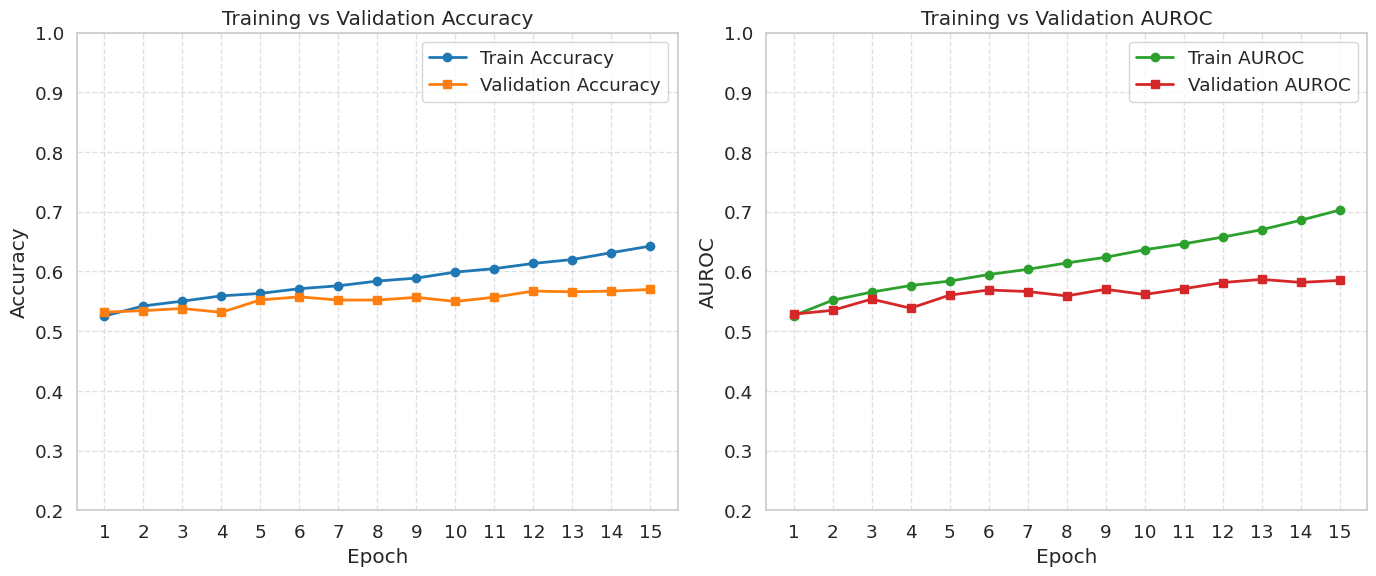

Training samples: 60365
Testing samples: 10762
Sample training item: ('flow_data/original_sequences/actors/c23/videos/01__hugging_happy/flow_image_147.png', 0)


100%|██████████| 43/43 [00:26<00:00,  1.61it/s]


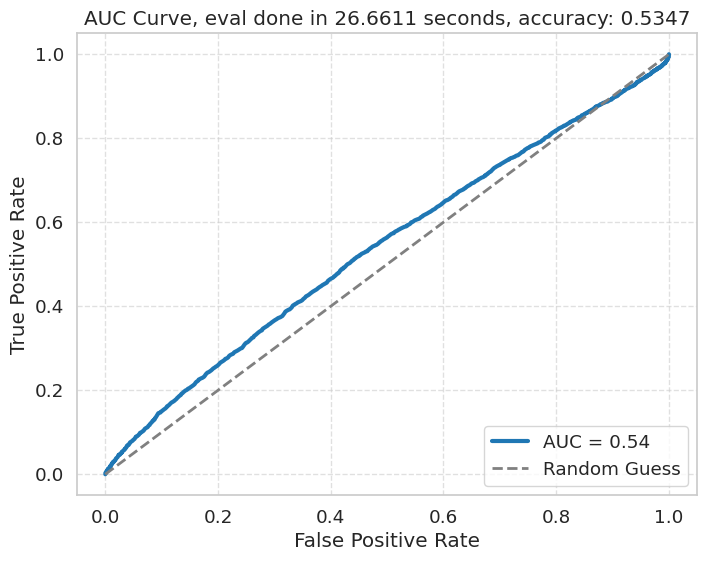

In [49]:
run_test("flow_dinov2_base_fp16", original_sources_flow, manipulated_sources_flow)

#### Results of depth model quantized to float 16

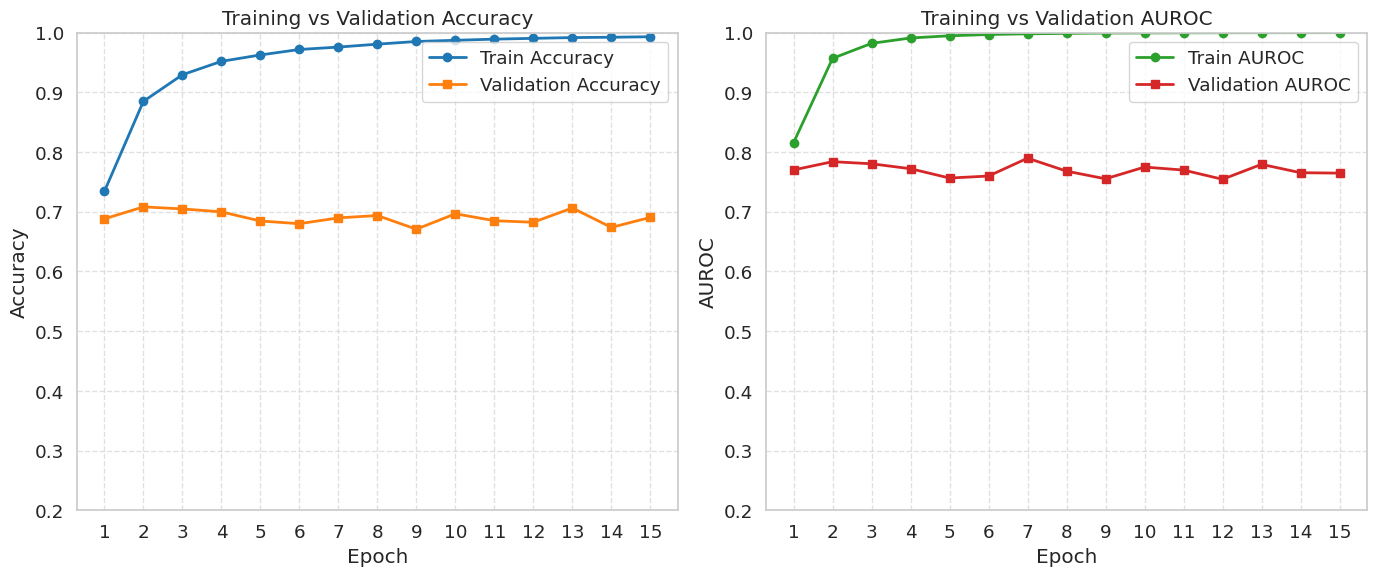

Training samples: 60447
Testing samples: 10777
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_354.png', 0)


100%|██████████| 43/43 [00:25<00:00,  1.67it/s]


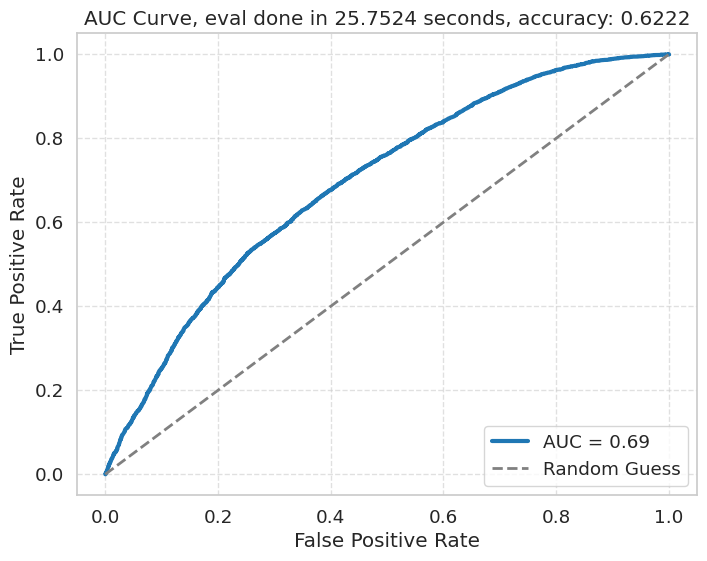

In [57]:
run_test("depth_dinov2_base_fp16", original_sources_depth, manipulated_sources_depth)

#### Results of depth model with float 32

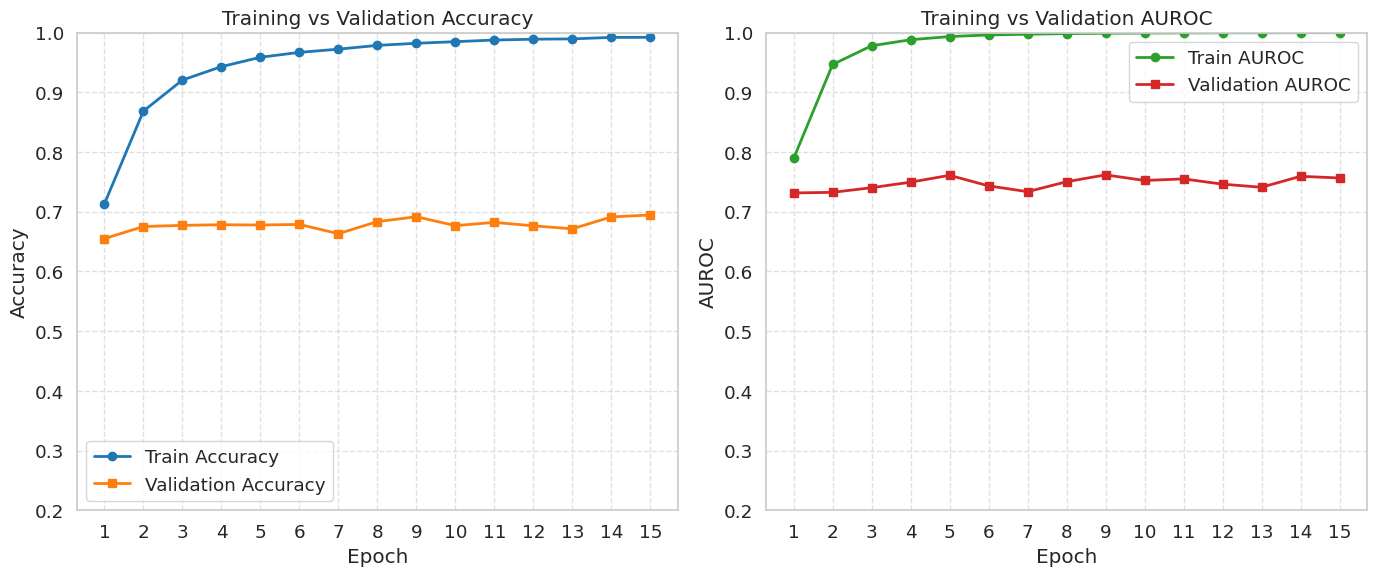

Training samples: 60447
Testing samples: 10777
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_354.png', 0)


100%|██████████| 43/43 [01:17<00:00,  1.81s/it]


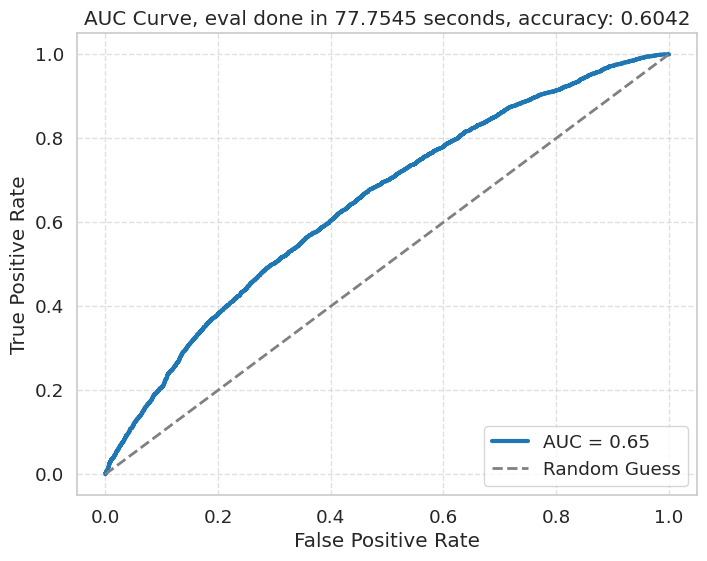

In [58]:
run_test("depth_dinov2_base_fp32", original_sources_depth, manipulated_sources_depth, scale=False)

#### Results of depth model quantized float 16 using small backbone

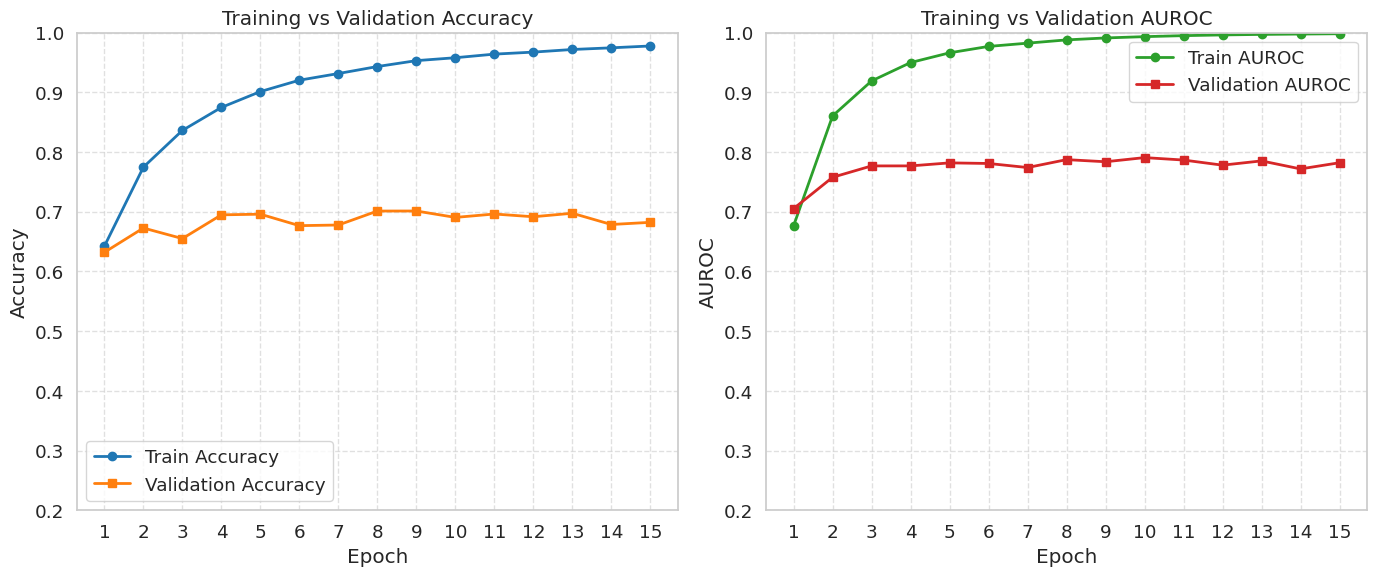

Training samples: 60447
Testing samples: 10777
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_354.png', 0)


100%|██████████| 43/43 [00:11<00:00,  3.82it/s]


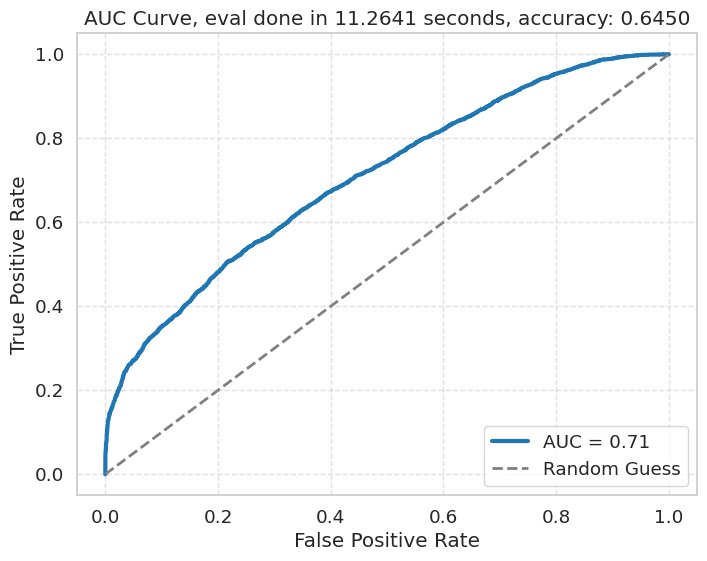

In [59]:
run_test("depth_dinov2_small_fp16", original_sources_depth, manipulated_sources_depth, backbone_name="facebook/dinov2-small")

#### Results of depth model quantized float 16 using small backbone distilled from breptrained base backbone

In [ ]:
backbone = prepare_backbone("facebook/dinov2-small")
model_name = "depth_dinov2_small_fp16_distilled"

model = DinoBinaryClassifierForDistilattion(backbone)
model.inference = True
model.to(DEVICE)
model_data = torch.load( os.path.join("checkpoints", f"{model_name}_final.pth"))
model.load_state_dict(model_data["model_state_dict"])
run_test(model_name, original_sources_depth, manipulated_sources_depth, model=model)

In [60]:
!cp -r training_progress '/content/drive/MyDrive/Colab Data/'